In [1]:
{
    "tags": [
        "hide_input",
        "hide_output"
    ]
}
import pandas as pd 
import numpy as np
import seaborn as sns

# PECARN TBI

In [2]:
pecarn_tbi = pd.read_csv('../data/TBI PUD 10-08-2013.csv', index_col=0)

# Data Types
The majority of the columns in the PECARN dataset are essentially categorical, with the exception of GCS and Age columns which are numeric.

It is helpful to convert everything to a nullable integer type (Int64) as there is some missing data, and then to a Categorical type.

In [3]:
for col in list(pecarn_tbi):
    try:
        pecarn_tbi[col] = pecarn_tbi[col].astype(float).astype('Int64')
        if col not in ['AgeinYears', 'AgeInMonth', 'GCSEye', 'GCSVerbal', 'GCSMotor', 'GCSTotal']:
            pecarn_tbi[col] = pecarn_tbi[col].astype('category')
    except:
        pass

# Initial Investigation
The *pecarn_tbi* dataframe will not be changed from this point onwards, and a *model_inputs* dataframe will be constructed.

In [4]:
model_inputs = pecarn_tbi

## Age
The dataset is evaluated by PECARN for two rule sets, one for a child below 2 years of age, and another for a child over 2 years of age.

We don't need both *AgeinYears* and *AgeInMonth*, but it may make sense to record infants age in months in the end-user UI


In [5]:
by_age_group = pecarn_tbi.groupby('AgeTwoPlus')
by_age_group['AgeinYears','AgeInMonth'].describe()

AgeinYears                                                 \
                count      mean       std  min  25%  50%   75%   max   
AgeTwoPlus                                                             
1             10904.0  0.501009  0.500022  0.0  0.0  1.0   1.0   1.0   
2             32495.0  8.621757  4.924099  2.0  4.0  8.0  13.0  17.0   

           AgeInMonth                                                          
                count        mean        std   min   25%    50%    75%    max  
AgeTwoPlus                                                                     
1             10904.0   11.588133   6.656089   0.0   6.0   12.0   17.0   23.0  
2             32495.0  108.871888  59.279896  24.0  53.0  103.0  163.0  215.0

Lets drop AgeInMonth for now... and fix up the typo while we are at it.

In [6]:
if 'AgeInMonth' in list(model_inputs):
    model_inputs = model_inputs.drop(columns='AgeInMonth')
model_inputs.rename(columns={'AgeinYears': 'Age'}, inplace=True)

We can also assume that the *AgeTwoPlus* category is something that a machine learning algorithm should learn, so we can remove it.

In [7]:
model_inputs = model_inputs.drop(columns='AgeTwoPlus')

## Employee Type and Certification
It may be valuable to weight the responses from a more experienced practioner. But for now, lets exclude the employee type as not relevant on the diagnosis.

In [8]:
model_inputs = model_inputs.drop(columns='EmplType')
model_inputs = model_inputs.drop(columns='Certification')

## Injury Type
The study reports *"Children were excluded with trivial injury mechanisms defined by ground-level falls or walking or running into stationary objects, and no signs or symptoms of head trauma other than scalp abrasions and lacerations.*"

Can't tell if the statement above means they have already been excluded. So need to investigate.

### Trivial Injury Mechanisms

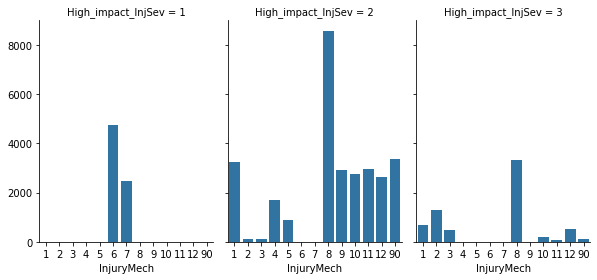

In [9]:
g = sns.FacetGrid(model_inputs, col='High_impact_InjSev', height=4, aspect=.7)
g.map(sns.countplot, 'InjuryMech')

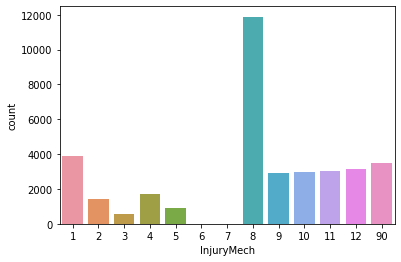

In [10]:
sns.countplot(model_inputs[model_inputs['High_impact_InjSev'] != 1]['InjuryMech'])

It looks like InjMech = 6 (Fall to ground from standing/walking/running) and InjMech = 7 (Walked or ran into stationary object) are in the data.

It also looks like *High_impact_InjSev* category 1 will exclude the *InjuryMech* category 6 and 7, which appear to be in the dataset, but should be excluded.

In [11]:
model_inputs = model_inputs[model_inputs['High_impact_InjSev'] != 1]

Patients were also excluded if they had penetrating trauma, known brain tumors, pre-existing neurological disorders complicating assessment, or neuroimaging at an outside hospital before transfer.

Patients were excluded if they had ventricular shunts or bleeding disorders.

Can't yet see where these statements are in the data...

## CT Ordered and Reason for CT
The *CTForm1* and *Ind###* columns appear to be confirmation that a CT scan iis being ordered, and a "reasoning" from the medical practitioner after they have decided to order a CT scan.

As we are trying to make the decision the reasoning should be driven from other input data (?) and these should be excluded.

Similarly, the *Findings###* columns appear to be assessing the CT scan. As we are not trying to predict the CT scan result, just whether we need to do a CT scan, these are being excluded for now (?).

For now, removing these columns.

In [12]:
if 'CTForm1' in list(model_inputs):
    model_inputs = model_inputs.drop(columns='CTForm1')

for col in list(model_inputs):
    if col.startswith('Ind'):
        model_inputs = model_inputs.drop(columns=col)

for col in list(model_inputs):
    if col.startswith('Finding'):
        model_inputs = model_inputs.drop(columns=col)        

## Remaining Columns
The following variables/columns are left:

In [13]:
pd.set_option('display.max_rows', 125)
model_inputs.dtypes

InjuryMech            category
High_impact_InjSev    category
Amnesia_verb          category
LOCSeparate           category
LocLen                category
Seiz                  category
SeizOccur             category
SeizLen               category
ActNorm               category
HA_verb               category
HASeverity            category
HAStart               category
Vomit                 category
VomitNbr              category
VomitStart            category
VomitLast             category
Dizzy                 category
Intubated             category
Paralyzed             category
Sedated               category
GCSEye                   Int64
GCSVerbal                Int64
GCSMotor                 Int64
GCSTotal                 Int64
GCSGroup              category
AMS                   category
AMSAgitated           category
AMSSleep              category
AMSSlow               category
AMSRepeat             category
AMSOth                category
SFxPalp               category
SFxPalpD

# Imbalanced Data
It looks like the data is quite imbalanced.

TODO: need to decide how to handle this.

In [14]:
model_inputs.groupby(['PosIntFinal']).count()

,InjuryMech,High_impact_InjSev,Amnesia_verb,LOCSeparate,LocLen,Seiz,SeizOccur,SeizLen,ActNorm,HA_verb,...,Observed,EDDisposition,CTDone,EDCT,PosCT,DeathTBI,HospHead,HospHeadPosCT,Intub24Head,Neurosurgery
PosIntFinal,,,,,,,,,,,,,,,,,,,,,
0,35142,35142,33322,33641,33067,34535,35100,35074,32369,34687,...,33210,35126,35142,35142,35142,35139,35141,35142,35140,35141
1,717,717,588,599,499,586,707,696,453,608,...,657,715,717,717,717,717,717,717,716,717


# Response Variables
In the original dataset, the *PosIntFinal* variable is the response or target variable. 

However, *PosIntFinal* variable is "Yes" when at least one of the *HospHeadPosCT*, *Intub24Head*, *Neurosurgery*, or *DeathTBI* variables were "Yes". The model probably doesn't need to predict the category (?)

In [15]:
responses_all_colnames = ['PosIntFinal', 'HospHeadPosCT', 'Intub24Head', 'Neurosurgery','DeathTBI']
pecarn_tbi[responses_all_colnames].describe()

,PosIntFinal,HospHeadPosCT,Intub24Head,Neurosurgery,DeathTBI
count,43379,43399,43395,43398,43391
unique,2,2,2,2,2
top,0,0,0,0,0
freq,42616,42706,43204,43198,43325


In [16]:
model_inputs[responses_all_colnames].describe()

,PosIntFinal,HospHeadPosCT,Intub24Head,Neurosurgery,DeathTBI
count,35859,35877,35874,35876,35872
unique,2,2,2,2,2
top,0,0,0,0,0
freq,35142,35225,35689,35685,35810
